https://blog.naver.com/jewdsa813/222200570774

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

# 다변수 칼만 필터
- 여러가지 확률변수 필터링하기

In [ ]:
%matplotlib inline
import book_format
book_format.set_style()

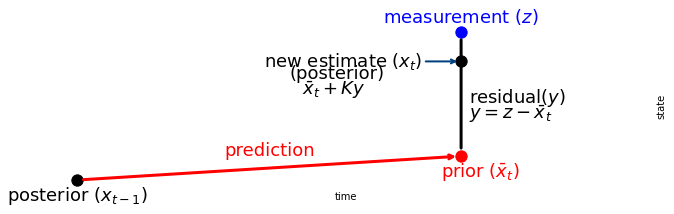

In [2]:
# 알고리즘 그래픽
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

### 1차원에서 개 추적하기, 가우스 함수를 곱하고 추가하기..

* 개 시뮬레이션 작성
* 시뮬레이션은 각 카운트 단계에 대해 실행
* 각 단계마다 개를 1미터 앞으로 이동
* 각 단계에서 속도는 프로세스 분산(process_var)에 따라 달라짐
* 위치를 업데이트 한 뒤 센서 분산(z_var)으로 측정 계산
* 이 함수는 측정값과 위치의 NumPy array 반환

### 예측 단계(predict step)
* 상태 및 공분산(x, P), 프로세스 모델 및 프로세스 노이즈(F, Q), 선택사항 으로 제어 입력 설계


- 평균은 가장 가능성이 높은 위치, 분산은 위치의 확률분포, 위치는 시스템의 상태, 이때 평균을 상태변수라고 함
- 상태변수는 센서로 직접 측정되는 관측변수거나, 관찰된 변수에서 유추한 숨겨진 변수일 수 있음
- 위치와 속도를 모두 추적하기 위해서 상태벡터 x, 공분산행렬 P로 표현된 가우스 함수 사용
- 개 추적 문제의 경우 센서가 위치만 판독하므로 위치가 관찰되고 속도가 숨겨짐, 숨겨진 변수를 추적


In [3]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1):
  "return track, measurement 1D ndarrays"
  x, vel = 1., 1. # 위치, 속도
  z_std = math.sqrt(z_var)
  p_std = math.sqrt(process_var)
  xs, zs = [], [] # 예측치, 측정값?
  for _ in range(count):
    v = vel + (randn() * p_std)
    x += v * dt
    xs.append(x)
    zs.append(x + randn() * z_std)
  return np.array(xs), np.array(zs)

* 상태 변수 설계

In [5]:
# 상태변수, x를 초기화
x = np.array([[10.0], [4.5]])
x

array([[10. ],
       [ 4.5]])

In [6]:
# 행벡터 -> 열백터, 전치 사용
x = np.array([[10.0, 4.5]]).T
x

array([[10. ],
       [ 4.5]])

In [7]:
# numpy는 1D array를 벡터로 인식함, 1D array로 표기
x = np.array([10.0, 4.5])
x


array([10. ,  4.5])

In [8]:
# 형태 한가지로 통일 float 한개만 있어도 전체 다 float 처리 됨
np.array([1., 0, 0, 0, 0])

array([1., 0., 0., 0., 0.])

In [10]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.], [4.5]])
print(np.dot(A, x))
print(A @ x)


[[19.]
 [48.]]
[[19.]
 [48.]]


In [11]:
x = np.array([[10., 4.5]]).T
print(A @ x)

x = np.array([10.0, 4.5])
print(A @ x) # 1D array 형식으로 반환되지만 칼만필터는 이 구조체를 벡터로 잘 인식됨

[[19.]
 [48.]]
[19. 48.]


* 상태 공분산 설계, P
> 공분산행렬 P
> * 1차원 칼만필터: 분산에 대한 초깃값을 지정한 후 필터에 측정값을 추가하여 추정값 업데이트
> * 다차원 칼만필터: 공분산 P에 대한 초깃값 지정한 후 필터는 각 기간이 지날때마다 업데이트
> - 공분산 행렬의 대각선에는 각 변수의 분산이 포함, 비대각 원소는 공분산 포함

In [13]:
# numpy.diag, 비대각 원소에 0이 있는 행렬
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

In [15]:
P = np.array([[500., 0.], [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

* 프로세스 모델 설계, F

> 시스템 동작 설명하는 수학적 모델

> 필터는 프로세스 모델을 사용해 이산시간 단계 이후 상태 예측

> 시스템의 역학을 설명하는 일련의 방정식을 가지고 프로세스 모델 설계

In [ ]:
# 1차원..
def predect(pos, movement):
  return gaussian(pos.mean + movement.mean, pos.var + movement.var)

![행렬곱](https://blogfiles.pstatic.net/MjAyMTAxMDNfMjc2/MDAxNjA5Njc3NTYyNzgx.IakFmhNfSlL_LBCYhY-Vq3cv6kWVJ_AcgUOGfy_8XSog.eNgmGo3yGiFse37otDo_Fyi5IhuUTCyom1XyMso0Mcog.PNG.jewdsa813/image.png?type=w1)

In [2]:
import numpy as np
from scipy.linalg import solve
A = np.array([[2, 3], [4, -1]])
B = np.array([[8], [2]])
x = solve(A, B)
x

array([[1.],
       [2.]])

* x예측 = Fx, 시스템에 대한 예측 수행하는 식
* 값을 예측 하는 값 F를 지정할 수 있어야 한다


* 개의 위치, 속도 예측할 때 "위치 예측하는데 필요한 방정식을 알고 있음"
* 속도에 대한 방정식은 모름 -> 속도가 일정하게 유지된다고 가정, 정확한 사실은 아니지만 속도가 많이 변하지 않는 한 필터는 잘 동작할 것
* 프로세스 모델 식
![프로세스모델](https://blogfiles.pstatic.net/MjAyMTAxMDNfMjgw/MDAxNjA5Njc4MDE0NzE1.mly-c1d33B8cYxzX2CE5Zes2pMpVLOml0ph1foIwXQQg.og1vTUIxsh37ALI9zAcYs4st3MXYeQ9SBOSpeDU9bFYg.PNG.jewdsa813/image.png)
![행렬](https://blogfiles.pstatic.net/MjAyMTAxMDNfMjIx/MDAxNjA5Njc4MDI0OTUx.gmTz2D7N_qPcVHiDRxZxJg-GSYsb253kbKTqpb5U_oAg.ffHVe6la3W7z9o-TWISeVXxQjd2Meu7g7OZd5n8ihYYg.PNG.jewdsa813/image.png)

* F를 상태 전달(전이) 함수, 상태 전달(전이) 행렬 이라 함, 함수가 좀더 일반적..?

In [3]:
dt = 0.1
F = np.array([[1, dt], [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

* FilterPy의 predict 함수
- 위치 10.0, 속도 4.5m/s, dt=0.1, 시간단계는 0.1초이고 한단계 진행 후 새 위치는 10.45가 될 것으로 예측, 속도는 변하지 않을 것

In [6]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49]) # 공분산
F = np.array([[1, dt], [0, 1]])

# Q 는 프로세스 노이즈
x, P = predict(x=x, P=P, F=F, Q=0)
print('x=', x)

x= [10.45  4.5 ]


In [7]:
# predict()함수 여러번 호출, 각 단계에 대한 업데이트
for _ in range(4):
  x, P = predict(x=x, P=P, F=F, Q=0)
  print('x=', x)

x= [10.9  4.5]
x= [11.35  4.5 ]
x= [11.8  4.5]
x= [12.25  4.5 ]


In [8]:
# 5번째 예측한 뒤의 P, 공분산 -> 측정없이 예측 단계를 5번 수행하여 불확실성이 더 커졌음(대각 원소인 위치 분산값이 더 커짐)
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


* 예측 전후의 공분산 표시

> 초기값: 빨간색

> 사전(예측): 검은색 점선

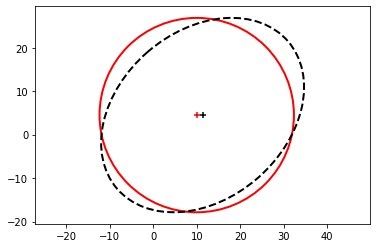

In [9]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')

x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

* 위치가 변경되었기 때문에 타원의 중심 이동(->방향)
* 타원의 형태가 길어지는 모습에서 위치와 속도 사이의 상관 관계를 보여줌
* 어떻게 P에 대한 새로운값 계산..? 무엇을 기반으로..? 노이즈 Q는 0으로 설정했는데..?
* -> 예측 단계는 정보손실을 수반...?

* 프로세스 노이즈 설계, Q
- 프로세스 노이즈의 공분산 행렬 Q + 공분산 행렬 P => 시스템 노이즈 설명
- 화이트 노이즈: 노이즈의 평균 0, x값도 바뀌지 않음


* 1차원, 단일변수 칼만 필터
> 예측 단계의 분산: var = var + process_noise


* 다번수 칼만필터(본질적으로 동일, 공분산 방정식에는 노이즈와 무관한 단어들이 있기 때문에 본질적 동일이라고 함)
> P = P + Q


* 프로세스 노이즈 행렬 도출 어려움..
> 현재 Q = E[wwT] 로 계산되는 화이트노이즈 w의 예상값과 같음...?
> Q를 변경하면 어떻게 변경되는지 직관적 이해...?


* FilterPy는 운동학적 문제에서 Q를 계산하는 기능 제공
* Q_discrete_white_noise 는 3개의 파라미터 제공
> dim: 행렬의 차원, dt: 시간단계(초), var: 노이즈 분ㄴ산
> 시간당 노이즈를 이산화

In [10]:
# 2.35의 분산과 1초의 시간 단계의 화이트노이즈에 대한 Q
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


* 조종함수 설계(Control Function)
> 칼만필터는 로봇이나 비행기 같은 시스템의 제어 입력 등을 결과값에 통합
> * 단계마다 원하는 위치와 현재 위치를 기준으로 로봇의 조종각과 속도 신호를 전송 -> (칼만필터 방정식) -> 제어 입력값들에 기초해 예측된 위치 생성
> * 정보를 버리지 않는다!!


* 선형 시스템에서 제어 입력은 선형 방정식의 집합으로 설명 가능, 선형 대수학 사용


* 델타x = Bu
> u: 제어 입력(control input), B: 제어 입력 모델/ 제어함수(control input model/control function)
> ex) u는 바퀴에 연결된 모터 회전속도 제어하는 전압일 수 있으며 B에 델타x값을 곱함
>   제어 입력으로 인해 변화되는 x의 양 구해야 함

* 이전 평균에 대한 완전한 칼만필터 방정식: x바 = Fx + Bu => KalmanFilter.predict()를 호출할 때 계산되는 방정식


* 개는 부르느 소리에 반응하도록 훈련 받았을 수도 있지만 제어 입력을 전혀 가지고 있지 않다고 가정 -> B = 0으로 설정

In [11]:
B = 0. # 개는 부르는 소리에 반응하지 않음
u = 0
x, P = predict(x, P, F, Q, B, u) # 예측 값
print('x = ', x)
print('P =', P)

x =  [12.7  4.5]
P = [[680.5875 301.175 ]
 [301.175  502.35  ]]


In [12]:
# predict의 매개변수의 기본값은 0 이므로, u, B를 0으로 설정할 필요 없음
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0] # x

array([ True,  True])

In [13]:
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1] # P

array([[ True,  True],
       [ True,  True]])

* 예측 요약
필터 디자이너로서의 역할은 다음 행렬들을 지정하는 것입니다.
- x, P: 상태와 공분산 행렬
- F, Q: 프로세스 모델과 프로세스 노이즈 공분산
- B, u: 옵션, 제어 입력과 제어 함수


---

### 갱신 단계(Update Step)
\- 두개 행렬(측정함수, 측정) 입력

* 측정 함수 설계(Measure Function), H

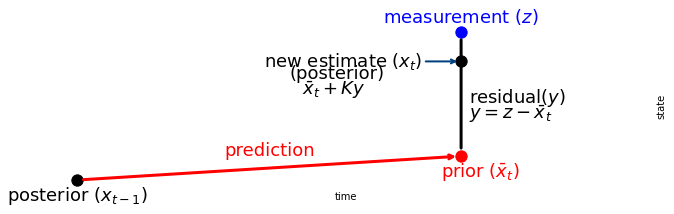

In [14]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

![이미지](https://blogfiles.pstatic.net/MjAyMTAxMDRfMTc0/MDAxNjA5NzMwNTc2MTQ1.OSpFx48HmIV4lZH4uDR132Z6_a1a4-GdtsFl_lNEXl8g.XkmbAvujlrf9SVG5mlUAAcoXpQN_EZX8k0SV3khfMocg.PNG.jewdsa813/image.png?type=w1)

H = [1 0]

In [17]:
H = np.array([1., 0.])

* 측정 설계(Design the Measurement)

* 측정은 측정평균 z와 측정 노이즈 공분산 행렬 R로 구현
* 측정값은 측정치 개수에 따라 다르게 표현됨(행렬)
* 측정 노이즈 행렬은 센서의 노이즈를 공분산 행렬로 모델링